## Interactive model tester
This allows interactive use of a saved Estimator model against systems configured for the **formal-test-set**.

In [1]:
from pathlib import Path
import re
from textwrap import fill

import numpy as np
import astropy.units as u
from uncertainties import ufloat, UFloat, unumpy

%matplotlib widget 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Support for interactive widgets
from IPython.display import *
from ipywidgets import *

from ebop_maven.libs import jktebop
from ebop_maven import pipeline, plotting
from ebop_maven.estimator import Estimator
import model_testing

from traininglib import formal_testing

### Create our Estimator
Loads the trained machine learning model into an Estimator class. The Estimator makes the model easier to use by handling inputs & outputs, naming features & labels and any scaling of label values.

In [2]:
# Default option is the model saved and published under ebop_maven/data/estimator
# Then we pick up any models built by make_trained_cnn_model & saved to ./drop/training/**
options = [("estimator/default-model", Path("./ebop_maven/data/estimator/default-model.keras"))] \
    + [(f"{f.parent.name}", f) for f in sorted((Path.cwd() / "drop/training").glob("**/*.keras"))]

model_selection = Dropdown(options=options, value=options[0][1], description="Models: ")
display(model_selection)

Dropdown(description='Models: ', options=(('estimator/default-model', PosixPath('ebop_maven/data/estimator/def…

In [3]:
estimator = Estimator(model=model_selection.get_interact_value())

Estimator loading model file 'ebop_maven/data/estimator/default-model.keras'...
Loaded model 'CNN-New-Ext0-bP-4096-0.75-250k' last modified at 2024-06-07T12:38:45.547849.
The prediction inputs are:
 	mags_feature - numpy ndarray[float] shape (#instances, 4096) with the phases after 0.75 wrapped by -1
	extra_features - numpy ndarray shape (#instances, 0) or None as extra_features are not used for predictions
The prediction results are:
 	predicted values as an numpy recarray[UFloat] of shape (#instances, [rA_plus_rB, k, J, ecosw, esinw, bP])
 	optionally raw predictions as a numpy NDArray[float] of shape (#instances, 6, #iterations), if include_raw==True


### Target selection
These targets are taken from the **formal-test-dataset**. These are accompanied with published parameters which we can use to test our results. Targets marked with an asterisk have been excluded from formal testing.

In [4]:
# Our initial target and where to source fitting inputs
default_target = "RR Lyn"
do_control_fit = False

targets_config_file = Path.cwd() / "config" / "formal-test-dataset.json"
targets_cfg = dict(formal_testing.iterate_target_configs(targets_config_file, include_excluded=True))

options = [(f"{t} *" if c.get("exclude", False) else f"{t}", t) for t, c in targets_cfg.items()]
target_selection = Dropdown(options=options, value=default_target, description="Targets:")
display(target_selection)

Dropdown(description='Targets:', index=10, options=(('V436 Per', 'V436 Per'), ('V539 Ara', 'V539 Ara'), ('MU C…

### Ingest the lightcurves
Searches for the target in the MAST archive and downloads timeseries fits files. Subsequent calls may be serviced from a local cache.

For each lightcurve we perform the following initial ingest actions:
- mask out rows where the quality column matches the quality_bitmask from the target's config
- optionally mask out any distorted regions indicated by quality_mask (from, to) time ranges in the target's config
- optionally bin the lightcurve as indicated by any bin_time item in the target's config
- generate delta_mag and delta_mag_err differential magnitude columns
- de-trend the lightcurve by fitting and subtracting a low-order polyomial
- create a phase-folded copy of the lightcurve, about the primary_epoch and period from the target's config

Once we have the phase-folded lightcurves we can fit an interpolated model to it
with the number of bins matching the input requirement of the Estimator's mag feature.
Alongside this we gather any further simple feature values the Estimator will require.

In [5]:
# Download, load and pre-process the target's lightcurve data
# which will be read, rectified & extended with delta_mag and delta_mag_err cols
target = target_selection.get_interact_value()
target_cfg = targets_cfg[target]
(lc, sector_count) = formal_testing.prepare_lightcurve_for_target(target, target_cfg)

# These are mandatory, so error if missing
labels = target_cfg["labels"]
period = target_cfg["period"] * u.d
pe = pipeline.to_lc_time(target_cfg["primary_epoch"], lc)

# Get the phase folded and binned mags feature
print(f"Creating phase normalized, folded lightcurves about", f"{pe.format} {pe} & {period}.")
mags_bins = estimator.mags_feature_bins
wrap_phase = estimator.mags_feature_wrap_phase
fold_lc = lc.fold(period, pe, wrap_phase=u.Quantity(wrap_phase), normalize_phase=True)
phases, mags = pipeline.get_sampled_phase_mags_data(flc=fold_lc, num_bins=mags_bins, phase_pivot=wrap_phase)

Searching for lightcurves based on; search term=RR Lyn, sectors=[20], mission=TESS, author=SPOC and exptime=short
Looking for previously downloaded fits within /home/steveo/projects/main/ebop_maven/cache/rr_lyn
Found 1 existing fits matching mission and author criteria
Found the required 1 fits file(s) meeting the TIC, sector & exptime criteria. Will load the requested lightcurves from these.
Opened light-curve fits for TIC 11491822 sector 20
NaN/negative flux masks match 0 row(s).
Creating a flatten transit mask from 2 transit time range(s) and the orbital period of 9.945126564 d.
Flattening the Light-curve
Will detrend (and rectify by subracting trends) over the following range [btjd]: 1842.508654-1868.826252
	Generated polynomial; y = poly(x, c0=5.626174e-04, c1=1.069227e-05) (sigma(fit_ydata)=8.363236e-05 mag)
Creating phase normalized, folded lightcurves about btjd 1851.926234608 & 9.945126564 d.


### Plot the target light-curve alongside the phase folded model
Make a plot of the ingested lightcurve with the position of the primary epoch
highlighted and the phase-folded lightcurve overlaid with the interpolated mags
feature which will be used as an input to the Estimator.

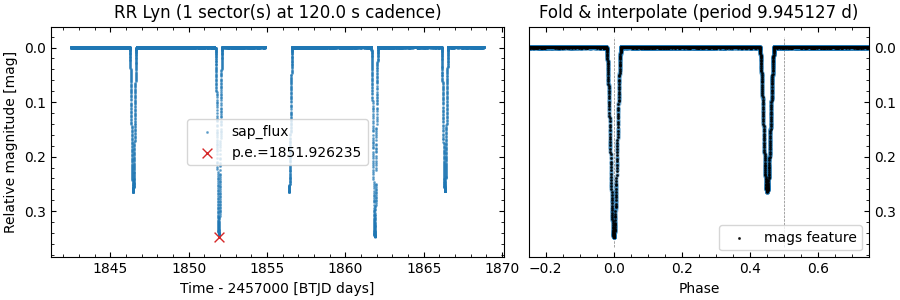

RR Lyn: An eccentric orbit with eclipses of approximately 0.35 and 0.25 mag and the secondary near
phase 0.45. Evidence of delta-Scuti & gamma-Dor pulsations. Our labels are taken from the solution
with third light.


In [6]:
target_label = target_cfg.get("label", target)
exptime = lc.meta["FRAMETIM"] * lc.meta["NUM_FRM"] * u.s  

fig = plt.figure(figsize=(9, 3), constrained_layout=True)
gs = GridSpec(figure=fig, ncols=2, nrows=1, width_ratios=(4, 3))
ax_lc = fig.add_subplot(gs[0, 0])
plotting.plot_lightcurve_on_axes(ax_lc, lc, "delta_mag", lc.meta["FLUX_ORIGIN"],
                                 primary_epoch=pe, primary_epoch_label=f"p.e.={pe.value:.6f}",
                                 ylabel="Relative magnitude [mag]", legend_loc="best", inverty=True,
                                 title=f"{target_label} ({sector_count} sector(s) at {exptime} cadence)")

ax_fld = fig.add_subplot(gs[0, 1], sharey=ax_lc)
plotting.plot_folded_lightcurve_on_axes(ax_fld, fold_lc, "delta_mag", None, show_phase_vlines=True,
                                        overlay_data=(phases, mags), overlay_data_label="mags feature",
                                        ylabel="", yticklabel_right=True, inverty=False,
                                        xlim=(min(phases), max(phases)), legend_loc="best",
                                        title=f"Fold & interpolate (period {period:.6f})")

plt.show()
print(fill(f"{target}: " + target_cfg.get("desc", ""), 100))

### Estimate the JKTEBOP fitting parameters
This is where the magic happens!

Estimator is used to predict the values of the $r_A+r_B$, $k$, $J$,
$e\cos{\omega}$, $e\sin{\omega}$ and $i$ parameters (or $b_P$ instead of $i$
if the model has been trained for it) for use as input values of subsequent
fitting with JKTEBOP.

If iterations >1 then the MC Dropout algorithm will be used which repeats the
requested predictions the given number of times with Dropout enabled. Dropout
randomly drops a proportion of the neurons in the full neural network, so in
this configuration each iteration will give a predition from a different subset
of the full network.

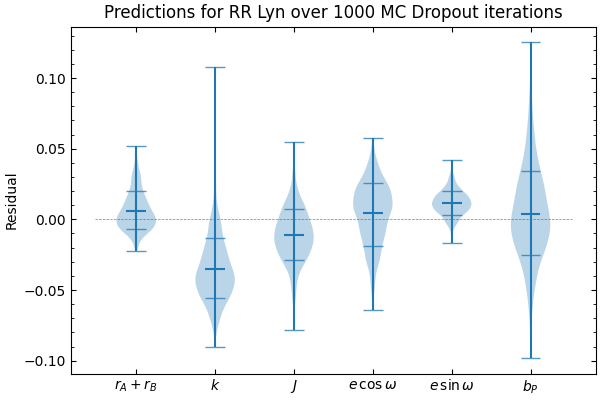

In [7]:
# The model predicts scaled values (e.g. inc*0.01) which the Estimator unscales. An  iterations > 1
# triggers the MC Dropout algorithm, where the predictions are mean & stddev of multiple predictions
# available, when include_raw_preds=True, as an ndarray[float] shape(#insts, #labels, #iterations).
iterations = 1000
predictions, raw_preds = estimator.predict(np.array([mags]), None, iterations, include_raw_preds=True)

# Get the labels into a structured array [UFloat] form for easy comparison downstream.
config_label_names = [k for k in labels if not k.endswith("_err")] # Just the nominals
label_values = np.array([tuple(ufloat(labels[k], 0) for k in config_label_names)],
                        dtype=[(k, np.dtype(UFloat.dtype)) for k in config_label_names])

if iterations > 1:
    # Plot the raw residuals; this will show us the distribution of each predicted param
    raw_labels = unumpy.nominal_values(label_values[estimator.label_names].tolist())
    raw_resids = raw_preds - raw_labels.transpose()
    fig, axes = plt.subplots(figsize=(6, 4), constrained_layout=True)
    plotting.plot_prediction_distributions_on_axes(axes, raw_resids, estimator.label_names,
                                violin_plot=True, show_1sigma_lines=True, ylabel="Residual",
                                title=f"Predictions for {target_label} over {iterations} MC Dropout iterations")
    plt.show()

The final output predictions will be the mean and 1-sigma values calculated
from the set of predictions from every iteration. The table shows the
predictions (nominals) against the (published) label values along with the
residual, MAE and MSE loss metrics.

In [8]:
# Handle the estimator predicting bP rather than inc directly; JKTEBOP uses inc
predicted_labels = list(predictions.dtype.names)
if "inc" not in predicted_labels and "bP" in predicted_labels:
    print(f"The {estimator.name} doesn't predict inc so it is calculated from other predictions")
    predictions = model_testing.append_calculated_inc_predictions(predictions)
    predicted_labels += ["inc"]

# Produce some statistics on the quality of the predictions.
print(f"The Estimator's predictions over {iterations} iteration(s) for {target}")
model_testing.predictions_vs_labels_to_table(predictions, label_values, target, predicted_labels)

The CNN-New-Ext0-bP-4096-0.75-250k doesn't predict inc so it is calculated from other predictions
The Estimator's predictions over 1000 iteration(s) for RR Lyn
---------------------------------------------------------------------------------------------------------------
RR Lyn     | rA_plus_rB          k          J      ecosw      esinw         bP        inc        MAE        MSE
---------------------------------------------------------------------------------------------------------------
Label      |   0.142060   0.629200   0.816000  -0.078061  -0.001600   0.510000  87.460000
Prediction |   0.147943   0.594177   0.804801  -0.073744   0.010023   0.513963  87.223326
O-C        |  -0.005883   0.035023   0.011199  -0.004317  -0.011623  -0.003963   0.236674   0.044097   0.008224
MAE        |   0.005883   0.035023   0.011199   0.004317   0.011623   0.003963   0.236674   0.044097
MSE        |   0.000035   0.001227   0.000125   0.000019   0.000135   0.000016   0.056015              0.008224

### Perform JKTEBOP fitting on the target's lightcurves
The parameters estimated above and the ingested lightcurves are now used to generate
an equivalent pair of in & dat files for the target. JKTEBOP is invoked against these
to fit the lightcurve with the EBOP algorithm.

In [9]:
# JKTEBOP won't overwrite files so make sure we clear down anything which could cause trouble
file_stem = f"int-tester-" + re.sub(r"[^\w\d-]", "-", target.lower())
for file in jktebop.get_jktebop_dir().glob(f"{file_stem}.*"):
    file.unlink()

in_filename = jktebop.get_jktebop_dir() / f"{file_stem}.in"
dat_filename = jktebop.get_jktebop_dir() / f"{file_stem}.dat"
par_filename = jktebop.get_jktebop_dir() / f"{file_stem}.par"

# We have the option of fitting the labels.
# This allows us to test whether a good fit can be achieved with appropriate inputs.
if do_control_fit:
    print("\033[93mWarning\033[0m: Control fit: labels are used for the fitting input parameters\n")
    input_params = label_values.copy()
else:
    input_params = predictions.copy()

# published fitting params that may be needed for good fit
fit_overrides = target_cfg.get("fit_overrides", {})
lrats = fit_overrides.get("lrat", [])

params = {
    **model_testing.base_jktebop_task3_params(
                    period.to(u.d).value, pe.value, dat_filename.name, file_stem, target_cfg),
    **{ n: input_params[0][n].nominal_value for n in input_params.dtype.names },    # predictions
    **fit_overrides,                                                                # overrides
}

# Add scale-factor poly fitting, chi^2 adjustment (to 1.0) or light-ratio instructions
segments = pipeline.find_lightcurve_segments(lc, 0.5, return_times=True)
append_lines = jktebop.build_poly_instructions(segments, "sf", 1)
append_lines += ["", "chif", ""] + [ f"lrat {l}" for l in lrats ]

jktebop.write_in_file(in_filename, task=3, append_lines=append_lines, **params)
jktebop.write_light_curve_to_dat_file(
    lc, dat_filename, column_formats=[lambda t: f"{t.value:.6f}", "%.6f", "%.6f"])

# Don't consume the output files so they're available for subsequent plotting
print(f"Fitting {target} using JKTEBOP task 3...")
par_contents = list(jktebop.run_jktebop_task(in_filename, par_filename, stdout_to=sys.stdout))

Fitting RR Lyn using JKTEBOP task 3...
  
JKTEBOP  v44  John Southworth (Keele University, UK, taylorsouthworth~gmail.com)
Task 3  finds the best fit of the model to observations  (formal errorbars only)
>> Read parameters for polynomial  1, to be applied to parameter "sf" over a given time interval
>> Read parameters for polynomial  2, to be applied to parameter "sf" over a given time interval
>> Opened new parameter  file:  int-tester-rr-lyn.par                             
>> Opened new LC output  file:  int-tester-rr-lyn.out                             
>> Opened new model fit  file:  int-tester-rr-lyn.fit                             
>> Read  17552 datapoints (with errors) from file int-tester-rr-lyn.dat                             
>> Read  2 polynomial datasets from the input file
>> Best fit has been found after 34 iterations.
>> Done iteration 1 to adjust errorbars. Chisqred values:  10.566 
>> Done iteration 2 to adjust errorbars. Chisqred values:   1.000 
>> Best fit has bee

### Review the JKTEBOP fitting results
For each fitted target, JKTEBOP produces parameter (par), model (fit) and
fitted lightcurve (out) files. We plot the phase folded lightcurve data
overlaid with the corresponding fitted model the out file.

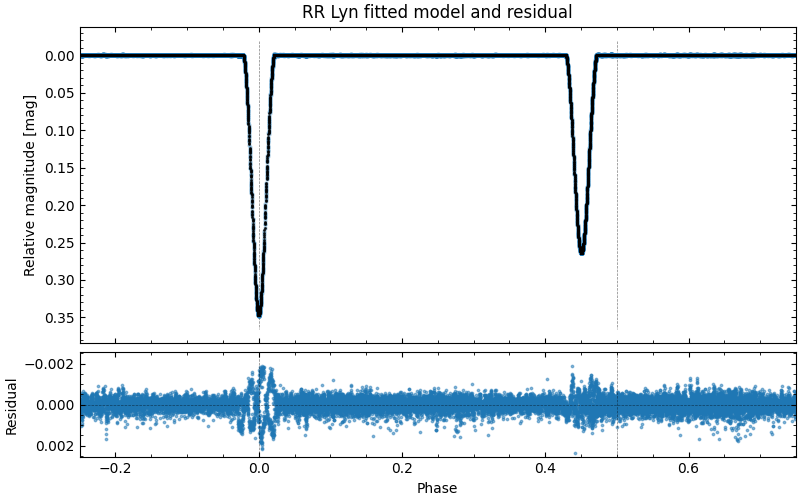

In [10]:
# Read the fit data from the out file, and roll the phases to match that used in estimations
with open(jktebop.get_jktebop_dir() /f"{file_stem}.out", mode="r", encoding="utf8") as ff:
    fit_data =  np.loadtxt(ff, usecols=[3, 4, 5], comments="#", dtype=np.double, unpack=True)
    fit_data[0][fit_data[0] > np.max(fold_lc.time).value] -= 1.

# A grid of two stacked Axes. Upper for the folded lc & model and lower for the residuals
fig = plt.figure(figsize=(8, 5), constrained_layout=True)
gs = GridSpec(figure=fig, ncols=1, nrows=2, height_ratios=(3, 1))
ax_fld = fig.add_subplot(gs[0, 0])

plotting.plot_folded_lightcurve_on_axes(ax_fld, fold_lc, "delta_mag", show_phase_vlines=True,
                                        overlay_data=fit_data, overlay_data_label=None,
                                        xlabel="", ylabel="Relative magnitude [mag]", inverty=True,
                                        title=f"{target_label} fitted model and residual")
plt.setp(ax_fld.get_xticklabels(), visible=False) # Hides xtick labels on this part shared axes

ax_res = fig.add_subplot(gs[1, 0], sharex=ax_fld)
ax_res.scatter(x=fit_data[0], y=fit_data[2], s=3, alpha=.5)
abs_max_ylim = max(np.abs(ax_res.get_ylim()))
plotting.format_axes(ax_res, title="", xlabel="Phase", ylabel="Residual",
                     xlim=(min(phases), max(phases)), ylim=(abs_max_ylim, -abs_max_ylim))
(ymin, ymax) = ax_res.get_ylim()
ax_res.vlines([0.0, 0.5], ymin, ymax, linestyles="--", color="k", lw=.5, alpha=.5)
ax_res.hlines([0.0], min(phases), max(phases), linestyles="--", color="k", lw=.5, alpha=.5)
plt.show()

In [11]:
# TODO: temp code to turn dict into structured array until jktebop is updated
fit_prms = ["rA_plus_rB", "k", "J", "ecosw", "esinw", "inc", "L3", "bP", "ecc", "omega", "rA", "rB"]
fitted_params = jktebop.read_fitted_params_from_par_lines(par_contents, fit_prms)
fitted_vals = np.array(tuple(ufloat(value[0], value[1]) for _, value in fitted_params.items()),
                       dtype=[(param, np.dtype(UFloat.dtype)) for param in fitted_params])

print(f"{target} JKTEBOP fitted parameters")
for param in fitted_vals.dtype.names:
    print(f"{param:>10s}: {fitted_vals[param]:10.6f}")

RR Lyn JKTEBOP fitted parameters
rA_plus_rB:   0.141884+/-  0.000128
         k:   0.627861+/-  0.000989
         J:   0.814152+/-  0.003750
     ecosw:  -0.078072+/-  0.000003
     esinw:   0.000874+/-  0.000419
       inc:  87.487685+/-  0.020878
        L3:   0.038467+/-  0.003052
        bP:   0.499413+/-         0
       ecc:   0.078076+/-         0
     omega: 179.358764+/-         0
        rA:   0.087160+/-         0
        rB:   0.054724+/-         0


In [12]:
print(f"The JKTEBOP model's fitted parameters vs the label values for {target}")
fitted_labels = ["inc" if n == "bP" else n for n in estimator.label_names]
model_testing.predictions_vs_labels_to_table(fitted_vals, label_values, target,
                                             fitted_labels, prediction_head="Fitted")

The JKTEBOP model's fitted parameters vs the label values for RR Lyn
----------------------------------------------------------------------------------------------------
RR Lyn     | rA_plus_rB          k          J      ecosw      esinw        inc        MAE        MSE
----------------------------------------------------------------------------------------------------
Label      |   0.142060   0.629200   0.816000  -0.078061  -0.001600  87.460000
Fitted     |   0.141884   0.627861   0.814152  -0.078072   0.000874  87.487685
O-C        |   0.000176   0.001339   0.001848   0.000011  -0.002474  -0.027685   0.005589   0.000130
MAE        |   0.000176   0.001339   0.001848   0.000011   0.002474   0.027685   0.005589
MSE        |   0.000000   0.000002   0.000003   0.000000   0.000006   0.000766              0.000130

